#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

#### Loading the data

In [2]:
fighter_details = pd.read_csv('./Data/fighter_details.csv')
fighter_details.head()

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Tom Aaron,NaN,155 lbs.,NaN,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Danny Abbadi,"5' 11""",155 lbs.,NaN,Orthodox,"Jul 03, 1983",3.29,38%,4.41,57%,0.00,0%,77%,0.0
2,David Abbott,"6' 0""",265 lbs.,NaN,Switch,NaN,1.35,30%,3.55,38%,1.07,33%,66%,0.0
3,Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2
4,Hiroyuki Abe,"5' 6""",145 lbs.,NaN,Orthodox,NaN,1.71,36%,3.11,63%,0.00,0%,33%,0.0


In [3]:
total_fight_data = pd.read_csv('./Data/total_fight_data.csv', sep = ';')
total_fight_data.head()

,R_fighter,B_fighter,R_KD,B_KD,R_SIG_STR.,B_SIG_STR.,R_SIG_STR_pct,B_SIG_STR_pct,R_TOTAL_STR.,B_TOTAL_STR.,...,B_GROUND,win_by,last_round,last_round_time,Format,Referee,date,location,Fight_type,Winner
0,Jack Hermansson,Marvin Vettori,0,1,122 of 346,164 of 334,35%,49%,139 of 365,202 of 376,...,8 of 13,Decision - Unanimous,5,5:00,5 Rnd (5-5-5-5-5),Herb Dean,"December 05, 2020","Las Vegas, Nevada, USA",Middleweight Bout,Marvin Vettori
1,Ovince Saint Preux,Jamahal Hill,0,0,36 of 72,68 of 128,50%,53%,37 of 73,68 of 128,...,0 of 0,KO/TKO,2,3:37,3 Rnd (5-5-5),Jason Herzog,"December 05, 2020","Las Vegas, Nevada, USA",Light Heavyweight Bout,Jamahal Hill
2,Gabriel Benitez,Justin Jaynes,1,0,38 of 104,22 of 52,36%,42%,38 of 104,22 of 52,...,0 of 0,KO/TKO,1,4:06,3 Rnd (5-5-5),NaN,"December 05, 2020","Las Vegas, Nevada, USA",Lightweight Bout,Gabriel Benitez
3,Roman Dolidze,John Allan,0,0,51 of 109,29 of 86,46%,33%,118 of 205,48 of 117,...,0 of 1,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,"December 05, 2020","Las Vegas, Nevada, USA",Light Heavyweight Bout,Roman Dolidze
4,Matt Wiman,Jordan Leavitt,0,0,0 of 2,1 of 1,0%,100%,0 of 2,1 of 1,...,0 of 0,KO/TKO,1,0:22,3 Rnd (5-5-5),Chris Tognoni,"December 05, 2020","Las Vegas, Nevada, USA",Lightweight Bout,Jordan Leavitt


#### Understanding the data - Exploratory Data Analysis

In [4]:
print('Number of unique fighters are:',len(fighter_details['fighter_name'].unique()))

Number of unique fighters are: 3578


In [5]:
fighter_details.dtypes

fighter_name     object
Height           object
Weight           object
Reach            object
Stance           object
DOB              object
SLpM            float64
Str_Acc          object
SApM            float64
Str_Def          object
TD_Avg          float64
TD_Acc           object
TD_Def           object
Sub_Avg         float64
dtype: object

In [6]:
fighter_details.isna().sum()

fighter_name       0
Height           261
Weight            74
Reach           1905
Stance           803
DOB              740
SLpM               0
Str_Acc            0
SApM               0
Str_Def            0
TD_Avg             0
TD_Acc             0
TD_Def             0
Sub_Avg            0
dtype: int64

In [7]:
fighter_details.describe()

,SLpM,SApM,TD_Avg,Sub_Avg
count,3578.000000,3578.000000,3578.000000,3578.000000
mean,2.287549,2.981283,1.212105,0.650475
std,1.916167,2.821903,1.917758,1.646941
min,0.000000,0.000000,0.000000,0.000000
25%,0.700000,1.380000,0.000000,0.000000
50%,2.160000,2.740000,0.510000,0.000000
75%,3.430000,4.000000,1.900000,0.800000
max,17.650000,52.500000,32.140000,29.000000


#### Cleaning up the data

In [8]:
total_fight_data.date.dtypes

dtype('O')

In [9]:
total_fight_data.date = pd.to_datetime(total_fight_data.date)

In [10]:
print('Oldest fight data is from:',min(total_fight_data.date))

Oldest fight data is from: 1994-03-11 00:00:00


##### Prior to 2001 UFC didn't have a lot of rules. So removing all the fights prior to 2001.

In [11]:
total_fight_data = total_fight_data[total_fight_data.date > '2001-01-01 00:00:00']

In [12]:
# Creating a list of all fighters from the fight dataset
fighter_list = (total_fight_data['R_fighter'].append(total_fight_data['B_fighter'])).unique()

In [13]:
print('Number of fighters who do not have details:', len(np.setdiff1d(fighter_list, fighter_details['fighter_name'])))

Number of fighters who do not have details: 0


#### Weight distribution of fighters

In [14]:
# Removing the fighter with 770 weight since he hasn't fought in any fights
fighter_details = fighter_details[fighter_details.fighter_name != 'Emmanuel Yarborough']

In [15]:
fighter_details.Weight[0]

'155 lbs.'

In [16]:
fighter_details.Weight = fighter_details.Weight.str.split(' ', expand = True)[0].astype('float')

<AxesSubplot:ylabel='Frequency'>

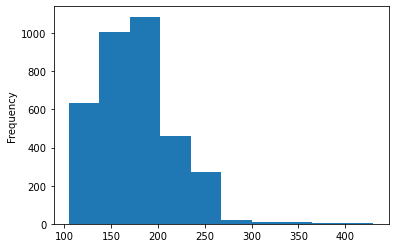

In [17]:
fighter_details.Weight.plot.hist(bins = 10)

In [18]:
max(fighter_details.Weight)

430.0

In [19]:
print('Number of Na values in the total_fight_data dataset: \n',total_fight_data.isna().sum())

Number of Na values in the total_fight_data dataset: 
 R_fighter           0
B_fighter           0
R_KD                0
B_KD                0
R_SIG_STR.          0
B_SIG_STR.          0
R_SIG_STR_pct       0
B_SIG_STR_pct       0
R_TOTAL_STR.        0
B_TOTAL_STR.        0
R_TD                0
B_TD                0
R_TD_pct            0
B_TD_pct            0
R_SUB_ATT           0
B_SUB_ATT           0
R_REV               0
B_REV               0
R_CTRL              0
B_CTRL              0
R_HEAD              0
B_HEAD              0
R_BODY              0
B_BODY              0
R_LEG               0
B_LEG               0
R_DISTANCE          0
B_DISTANCE          0
R_CLINCH            0
B_CLINCH            0
R_GROUND            0
B_GROUND            0
win_by              0
last_round          0
last_round_time     0
Format              0
Referee            30
date                0
location            0
Fight_type          0
Winner             99
dtype: int64


In [20]:
print('Breakdown of Win By conditions: \n', total_fight_data[total_fight_data.Winner.isnull()]['win_by'].value_counts())

Breakdown of Win By conditions: 
 Overturned              44
Decision - Majority     22
Could Not Continue      15
Decision - Split        13
Decision - Unanimous     4
Submission               1
Name: win_by, dtype: int64


#### What do each of these win by conditions mean?

Overturned: Decision was changed due failed drug test <br>
Could not continue: Fighter could not continue after illegal blow <br>
Rest all are various forms of draw

In [21]:
# Replacing all of these conditions with 'Draw'

total_fight_data['Winner'].fillna('Draw', inplace = True)

#### Feature Engineering

In [22]:
#Checking Fight_type
total_fight_data.Fight_type.value_counts()[total_fight_data.Fight_type.value_counts() > 1]

Lightweight Bout                            1008
Welterweight Bout                           1005
Middleweight Bout                            722
Featherweight Bout                           513
Light Heavyweight Bout                       512
Heavyweight Bout                             469
Bantamweight Bout                            437
Flyweight Bout                               202
Women's Strawweight Bout                     171
Women's Bantamweight Bout                    128
Women's Flyweight Bout                        97
UFC Light Heavyweight Title Bout              38
UFC Welterweight Title Bout                   35
Catch Weight Bout                             34
UFC Heavyweight Title Bout                    31
UFC Middleweight Title Bout                   29
UFC Lightweight Title Bout                    28
UFC Flyweight Title Bout                      16
UFC Featherweight Title Bout                  14
UFC Women's Bantamweight Title Bout           14
UFC Bantamweight Tit

In [23]:
#A flag to highlight whether the fight was wonen's only or not
total_fight_data['Is_Male_Fight'] = np.where(total_fight_data.Fight_type.str.contains("Women's"), 0, 1)

#### Creating a separate column for weight class

In [24]:
def assign_weight_class(weight_class):
    if 'Strawweight' in weight_class:
        return 'Strawweight'
    if 'Bantamweight' in weight_class:
        return 'Bantamweight'
    if 'Featherweight' in weight_class:
        return 'Featherweight'
    if 'Flyweight' in weight_class:
        return 'Flyweight'
    if 'Lightweight' in weight_class:
        return 'Lightweight'
    if 'Welterweight' in weight_class:
        return 'Welterweight'
    if 'Middleweight' in weight_class:
        return 'Middleweight'
    if 'Light Heavyweight' in weight_class:
        return 'Light Heavyweight'
    if 'Heavyweight' in weight_class:
        return 'Heavyweight'

In [25]:
total_fight_data['weight_class'] = total_fight_data.Fight_type.apply(assign_weight_class)

In [26]:
total_fight_data['Format'].value_counts()

3 Rnd (5-5-5)           5117
5 Rnd (5-5-5-5-5)        485
3 Rnd + OT (5-5-5-5)      22
2 Rnd (5-5)                3
Name: Format, dtype: int64

#### Calculating total fight time

In [27]:
def calculate_time(x):
    if x == '3 Rnd (5-5-5)':
        return 3 * 5 * 60
    if x == '5 Rnd (5-5-5-5-5)':
        return 5 * 5 * 60
    if x == '3 Rnd + OT (5-5-5-5)':
        return 4 * 5 * 60
    if x == '2 Rnd (5-5)':
        return 2 * 5 * 60

In [28]:
total_fight_data['total_time'] = total_fight_data.Format.apply(calculate_time)

#### Calculating number of rounds

In [29]:
def count_rounds(x):
    if x == '3 Rnd (5-5-5)':
        return 3
    if x == '5 Rnd (5-5-5-5-5)':
        return 5
    if x == '3 Rnd + OT (5-5-5-5)':
        return 4
    if x == '2 Rnd (5-5)':
        return 2

In [30]:
total_fight_data['total_rounds'] = total_fight_data.Format.apply(count_rounds)

In [31]:
# Reworking some of the columns

columns_to_split = ['R_SIG_STR.', 'B_SIG_STR.', 'R_TOTAL_STR.', 'B_TOTAL_STR.',
       'R_TD', 'B_TD', 'R_HEAD', 'B_HEAD', 'R_BODY','B_BODY', 'R_LEG', 'B_LEG', 
        'R_DISTANCE', 'B_DISTANCE', 'R_CLINCH','B_CLINCH', 'R_GROUND', 'B_GROUND']

In [32]:
attempt_suffix = '_att'
landed_suffix = '_landed'

for column in columns_to_split:
    total_fight_data[column+attempt_suffix] = total_fight_data[column].apply(lambda X: int(X.split('of')[1]))
    total_fight_data[column+landed_suffix] = total_fight_data[column].apply(lambda X: int(X.split('of')[0]))
    
total_fight_data.drop(columns_to_split, axis=1, inplace=True)

In [33]:
pct_columns = ['R_SIG_STR_pct','B_SIG_STR_pct', 'R_TD_pct', 'B_TD_pct']

def pct_to_frac(X):
    if X != '---':
        return float(X.replace('%', ''))/100
    else:
        return 0

for column in pct_columns:
    total_fight_data[column] = total_fight_data[column].apply(pct_to_frac)

In [34]:
total_fight_data.T

,0,1,2,3,4,5,6,7,8,9,...,5617,5618,5619,5620,5621,5622,5623,5624,5625,5626
R_fighter,Jack Hermansson,Ovince Saint Preux,Gabriel Benitez,Roman Dolidze,Matt Wiman,Louis Smolka,Ilia Topuria,Gian Villante,Anthony Smith,Miguel Baeza,...,BJ Penn,Tony DeSouza,Tito Ortiz,Jens Pulver,Fabiano Iha,Elvis Sinosic,Pedro Rizzo,Bobby Hoffman,Phil Baroni,Sean Sherk
B_fighter,Marvin Vettori,Jamahal Hill,Justin Jaynes,John Allan,Jordan Leavitt,Jose Quinonez,Damon Jackson,Jake Collier,Devin Clark,Takashi Sato,...,Joey Gilbert,Steve Berger,Evan Tanner,Caol Uno,Phil Johns,Jeremy Horn,Josh Barnett,Mark Robinson,Curtis Stout,Tiki Ghosn
R_KD,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
B_KD,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
R_SIG_STR_pct,0.35,0.5,0.36,0.46,0,0.5,0.49,0.4,0.25,0.54,...,0.68,0.58,1,0.38,0.5,0.4,0.36,0.86,0.72,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B_CLINCH_landed,0,6,0,1,0,4,1,2,0,0,...,2,0,0,7,1,0,10,0,0,0
R_GROUND_att,0,0,5,8,0,22,1,0,2,5,...,21,39,2,5,0,0,0,0,52,12
R_GROUND_landed,0,0,4,3,0,12,1,0,1,5,...,16,25,2,1,0,0,0,0,38,10
B_GROUND_att,13,0,0,1,0,2,0,0,0,1,...,0,0,0,2,0,2,0,0,0,0


#### Restructuring the dataset

Idea is to separate out the Red and Blue fighters and create a combined dataset as a union.

In [35]:
# Breaking the dataset into red and blue fighters

red_fighter_columns = []
blue_fighter_columns = []
common_columns = []

for column in total_fight_data.columns:
    if re.search(r'\bR_', column):
        red_fighter_columns.append(column)
        
    elif re.search(r'\bB_', column):
        blue_fighter_columns.append(column)
    
    else:
        common_columns.append(column)

In [36]:
common_columns

['win_by',
 'last_round',
 'last_round_time',
 'Format',
 'Referee',
 'date',
 'location',
 'Fight_type',
 'Winner',
 'Is_Male_Fight',
 'weight_class',
 'total_time',
 'total_rounds']

In [37]:
common_columns = ['Winner', 'Is_Male_Fight', 'date', 'win_by', 'weight_class']

In [38]:
red_fighter_df = total_fight_data[red_fighter_columns + common_columns]
blue_fighter_df = total_fight_data[blue_fighter_columns + common_columns]

In [39]:
red_fighter_columns = [re.sub(r'\bR_', '', x) for x in red_fighter_columns]
blue_fighter_columns = [re.sub(r'\bB_', '', x) for x in blue_fighter_columns]

In [40]:
red_fighter_df.columns = red_fighter_columns + common_columns
blue_fighter_df.columns = blue_fighter_columns + common_columns

#### Checking if both datasets have equal number of columns

In [41]:
set(blue_fighter_columns) - set(red_fighter_columns)

set()

In [42]:
set(red_fighter_columns) - set(blue_fighter_columns)

set()

In [43]:
#Combining both Red and Blue fighter data
red_blue_combined = pd.concat([red_fighter_df, blue_fighter_df])
red_blue_combined.head()

,fighter,KD,SIG_STR_pct,TD_pct,SUB_ATT,REV,CTRL,SIG_STR._att,SIG_STR._landed,TOTAL_STR._att,...,DISTANCE_landed,CLINCH_att,CLINCH_landed,GROUND_att,GROUND_landed,Winner,Is_Male_Fight,date,win_by,weight_class
0,Jack Hermansson,0,0.35,0.28,0,0,0:28,346,122,365,...,118,7,4,0,0,Marvin Vettori,1,2020-12-05,Decision - Unanimous,Middleweight
1,Ovince Saint Preux,0,0.50,0.00,0,0,0:00,72,36,73,...,35,2,1,0,0,Jamahal Hill,1,2020-12-05,KO/TKO,Light Heavyweight
2,Gabriel Benitez,1,0.36,0.00,0,0,0:00,104,38,104,...,34,0,0,5,4,Gabriel Benitez,1,2020-12-05,KO/TKO,Lightweight
3,Roman Dolidze,0,0.46,0.60,3,0,7:16,109,51,205,...,47,1,1,8,3,Roman Dolidze,1,2020-12-05,Decision - Split,Light Heavyweight
4,Matt Wiman,0,0.00,0.00,0,0,0:00,2,0,2,...,0,0,0,0,0,Jordan Leavitt,1,2020-12-05,KO/TKO,Lightweight


In [44]:
red_blue_combined['Win_Flag'] = np.where(red_blue_combined.fighter == red_blue_combined.Winner, 1, 0)

In [45]:
red_blue_combined.T

,0,1,2,3,4,5,6,7,8,9,...,5617,5618,5619,5620,5621,5622,5623,5624,5625,5626
fighter,Jack Hermansson,Ovince Saint Preux,Gabriel Benitez,Roman Dolidze,Matt Wiman,Louis Smolka,Ilia Topuria,Gian Villante,Anthony Smith,Miguel Baeza,...,Joey Gilbert,Steve Berger,Evan Tanner,Caol Uno,Phil Johns,Jeremy Horn,Josh Barnett,Mark Robinson,Curtis Stout,Tiki Ghosn
KD,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SIG_STR_pct,0.35,0.5,0.36,0.46,0,0.5,0.49,0.4,0.25,0.54,...,0.42,0.11,0,0.49,0.66,0.4,0.38,0,0.66,0.14
TD_pct,0.28,0,0,0.6,0,0.75,0,0,1,0.5,...,0,0,0,0.12,0,0,0,0,0,0
SUB_ATT,0,0,0,3,0,0,0,0,1,1,...,0,3,0,0,0,0,0,0,0,0
REV,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
CTRL,0:28,0:00,0:00,7:16,0:00,1:09,0:03,0:00,1:18,1:09,...,0:06,1:07,0:01,1:54,0:16,2:30,0:00,3:05,0:00,0:00
SIG_STR._att,346,72,104,109,2,116,63,197,4,73,...,7,18,1,101,3,10,101,1,3,7
SIG_STR._landed,122,36,38,51,0,59,31,80,1,40,...,3,2,0,50,2,4,39,0,2,1
TOTAL_STR._att,365,73,104,205,2,128,64,198,8,82,...,15,129,1,107,7,37,103,2,42,16


#### Converting a few columns before creating models

In [46]:
def convert_to_cms(X):
    if X is np.NaN:
        return X
    elif len(X.split("'")) == 2:
        feet = float(X.split("'")[0])
        inches = int(X.split("'")[1].replace(' ', '').replace('"',''))
        return (feet * 30.48) + (inches * 2.54)
    else:
        return float(X.replace('"','')) * 2.54

In [47]:
fighter_details['Height_cms'] = fighter_details['Height'].apply(convert_to_cms)
fighter_details['Reach_cms'] = fighter_details['Reach'].apply(convert_to_cms)

In [48]:
pct_columns = ['Str_Acc','Str_Def', 'TD_Acc', 'TD_Def']

def pct_to_frac(X):
    if X != np.NaN:
        return float(X.replace('%', ''))/100
    else:
        return 0

for column in pct_columns:
    fighter_details[column] = fighter_details[column].apply(pct_to_frac)

In [49]:
# Drop columns with too many NaNs
fighter_details.drop(['Height', 'Reach'], axis=1, inplace=True)

In [50]:
fighter_details.T

,0,1,2,3,4,5,6,7,8,9,...,3568,3569,3570,3571,3572,3573,3574,3575,3576,3577
fighter_name,Tom Aaron,Danny Abbadi,David Abbott,Shamil Abdurakhimov,Hiroyuki Abe,Daichi Abe,Papy Abedi,Ricardo Abreu,Klidson Abreu,Daniel Acacio,...,Mike Zichelle,James Zikic,Errol Zimmerman,Cat Zingano,Igor Zinoviev,Dave Zitanick,Alex Zuniga,George Zuniga,Allan Zuniga,Virgil Zwicker
Weight,155,155,265,235,145,170,185,185,205,180,...,205,205,185,145,199,170,145,185,155,205
Stance,NaN,Orthodox,Switch,Orthodox,Orthodox,Orthodox,Southpaw,Orthodox,Orthodox,Orthodox,...,NaN,Orthodox,Orthodox,Southpaw,Orthodox,NaN,NaN,NaN,Orthodox,NaN
DOB,"Jul 13, 1978","Jul 03, 1983",NaN,"Sep 02, 1981",NaN,"Nov 27, 1991","Jun 30, 1978","Apr 27, 1984","Dec 24, 1992","Dec 27, 1977",...,NaN,"Mar 01, 1977","Apr 20, 1986","Jul 01, 1982",NaN,"Mar 05, 1980",NaN,NaN,"Apr 04, 1992","Jun 26, 1982"
SLpM,0,3.29,1.35,2.45,1.71,3.8,2.8,3.79,2.05,3.52,...,0.87,1.47,2.95,2.57,0,0,0,7.64,3.93,3.34
Str_Acc,0,0.38,0.3,0.44,0.36,0.33,0.55,0.31,0.4,0.36,...,0.35,0.35,0.42,0.61,0,0,0,0.38,0.52,0.48
SApM,0,4.41,3.55,2.45,3.11,4.49,3.15,3.98,2.9,2.85,...,0.87,1.6,0,1.63,0,0,0,5.45,1.8,4.87
Str_Def,0,0.57,0.38,0.58,0.63,0.56,0.48,0.68,0.55,0.62,...,0.4,0.44,0,0.47,0,0,0,0.37,0.61,0.39
TD_Avg,0,0,1.07,1.23,0,0.33,3.47,2.13,0.64,0.33,...,0,0.5,0,2.77,0,0,0,0,0,1.31
TD_Acc,0,0,0.33,0.24,0,0.5,0.57,0.42,0.2,0.2,...,0,0.25,0,0.65,0,0,0,0,0,0.3


#### Combining data about each fight with individual fighters personal info

In [51]:
final_dataset = red_blue_combined.merge(fighter_details, left_on = 'fighter', right_on = 'fighter_name')
final_dataset.head()

,fighter,KD,SIG_STR_pct,TD_pct,SUB_ATT,REV,CTRL,SIG_STR._att,SIG_STR._landed,TOTAL_STR._att,...,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg,Height_cms,Reach_cms
0,Jack Hermansson,0,0.35,0.28,0,0,0:28,346,122,365,...,5.03,0.44,3.46,0.54,1.96,0.34,0.75,0.7,185.42,195.58
1,Jack Hermansson,0,0.50,0.00,1,0,0:00,4,2,4,...,5.03,0.44,3.46,0.54,1.96,0.34,0.75,0.7,185.42,195.58
2,Jack Hermansson,0,0.47,0.16,0,0,0:45,42,20,45,...,5.03,0.44,3.46,0.54,1.96,0.34,0.75,0.7,185.42,195.58
3,Jack Hermansson,0,0.79,1.00,0,0,1:38,29,23,47,...,5.03,0.44,3.46,0.54,1.96,0.34,0.75,0.7,185.42,195.58
4,Jack Hermansson,0,0.39,0.30,1,0,6:52,372,148,496,...,5.03,0.44,3.46,0.54,1.96,0.34,0.75,0.7,185.42,195.58


#### Calculate Age

In [52]:
fighter_details

,fighter_name,Weight,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg,Height_cms,Reach_cms
0,Tom Aaron,155.0,NaN,"Jul 13, 1978",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN
1,Danny Abbadi,155.0,Orthodox,"Jul 03, 1983",3.29,0.38,4.41,0.57,0.00,0.00,0.77,0.0,180.34,NaN
2,David Abbott,265.0,Switch,NaN,1.35,0.30,3.55,0.38,1.07,0.33,0.66,0.0,182.88,NaN
3,Shamil Abdurakhimov,235.0,Orthodox,"Sep 02, 1981",2.45,0.44,2.45,0.58,1.23,0.24,0.47,0.2,190.50,193.04
4,Hiroyuki Abe,145.0,Orthodox,NaN,1.71,0.36,3.11,0.63,0.00,0.00,0.33,0.0,167.64,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3573,Dave Zitanick,170.0,NaN,"Mar 05, 1980",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN
3574,Alex Zuniga,145.0,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,NaN,NaN
3575,George Zuniga,185.0,NaN,NaN,7.64,0.38,5.45,0.37,0.00,0.00,1.00,0.0,175.26,NaN
3576,Allan Zuniga,155.0,Orthodox,"Apr 04, 1992",3.93,0.52,1.80,0.61,0.00,0.00,0.57,1.0,170.18,177.80


#### Scrapping some of the calculations coz Age wasn't getting calculated properly

final_dataset['DOB'] = pd.to_datetime(final_dataset['DOB'])
final_dataset['date'] = pd.to_datetime(final_dataset['date'])

def get_age(row):
    age = (row['date'] - row['DOB']).days
    if np.isnan(age)!=True:
        age = math.floor(age/365.25)
    
    return age

final_dataset['age']= final_dataset[['date', 'DOB']].apply(get_age, axis=1)

final_dataset.drop(['DOB', 'date'], axis=1, inplace=True)

In [53]:
final_dataset = pd.concat([final_dataset, pd.get_dummies(final_dataset['win_by'], prefix='win_by', drop_first = True)], axis=1)
final_dataset.drop(['win_by'],axis=1, inplace=True)

In [54]:
final_dataset = pd.concat([final_dataset, pd.get_dummies(final_dataset['weight_class'], prefix='weight_class', drop_first = True)], axis=1)
final_dataset.drop(['weight_class'],axis=1, inplace=True)

In [55]:
final_dataset = pd.concat([final_dataset, pd.get_dummies(final_dataset['Stance'], prefix='Stance', drop_first = True)], axis=1)
final_dataset.drop(['Stance'],axis=1, inplace=True)

In [56]:
final_dataset.drop(['Winner', 'fighter', 'fighter_name', 'CTRL', 'Reach_cms', 'DOB', 'date'],axis=1, inplace=True)

In [57]:
final_dataset.T

,0,1,2,3,4,5,6,7,8,9,...,11244,11245,11246,11247,11248,11249,11250,11251,11252,11253
KD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SIG_STR_pct,0.35,0.50,0.47,0.79,0.39,0.30,0.69,0.62,0.17,0.70,...,0.66,0.00,0.34,0.50,0.50,0.33,1.00,0.42,0.66,0.00
TD_pct,0.28,0.00,0.16,1.00,0.30,0.50,0.50,1.00,0.00,1.00,...,0.25,0.00,0.00,0.66,0.00,0.00,0.00,0.00,0.00,0.00
SUB_ATT,0.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
REV,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
SIG_STR._att,346.00,4.00,42.00,29.00,372.00,10.00,59.00,56.00,28.00,54.00,...,9.00,1.00,23.00,8.00,2.00,3.00,2.00,7.00,3.00,1.00
SIG_STR._landed,122.00,2.00,20.00,23.00,148.00,3.00,41.00,35.00,5.00,38.00,...,6.00,0.00,8.00,4.00,1.00,1.00,2.00,3.00,2.00,0.00
TOTAL_STR._att,365.00,4.00,45.00,47.00,496.00,10.00,73.00,71.00,28.00,65.00,...,18.00,21.00,115.00,16.00,2.00,83.00,2.00,15.00,7.00,2.00
TOTAL_STR._landed,139.00,2.00,22.00,39.00,256.00,3.00,53.00,49.00,5.00,49.00,...,14.00,17.00,97.00,12.00,1.00,79.00,2.00,11.00,6.00,1.00
TD_att,7.00,1.00,6.00,1.00,10.00,2.00,2.00,3.00,2.00,1.00,...,4.00,0.00,2.00,3.00,0.00,2.00,1.00,1.00,1.00,0.00


In [58]:
final_dataset = final_dataset[final_dataset['Height_cms'].notna()]

#### Creating Test and Train datasets

In [59]:
X = final_dataset.loc[:, final_dataset.columns != 'Win_Flag']
y = final_dataset['Win_Flag']

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 888)

In [61]:
final_dataset.isna().sum()

KD                                0
SIG_STR_pct                       0
TD_pct                            0
SUB_ATT                           0
REV                               0
SIG_STR._att                      0
SIG_STR._landed                   0
TOTAL_STR._att                    0
TOTAL_STR._landed                 0
TD_att                            0
TD_landed                         0
HEAD_att                          0
HEAD_landed                       0
BODY_att                          0
BODY_landed                       0
LEG_att                           0
LEG_landed                        0
DISTANCE_att                      0
DISTANCE_landed                   0
CLINCH_att                        0
CLINCH_landed                     0
GROUND_att                        0
GROUND_landed                     0
Is_Male_Fight                     0
Win_Flag                          0
Weight                            0
SLpM                              0
Str_Acc                     

### Building Models

#### Lasso Regression

In [62]:
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 10000, normalize = True)
lassocv.fit(X_train, y_train)

LassoCV(cv=10, max_iter=10000, normalize=True)

In [68]:
y_pred_lasso = pre_prob_lasso.copy()
y_pred_lasso[y_pred_lasso>=0.5] = 1
y_pred_lasso[y_pred_lasso<0.5] = 0

In [69]:
print('Accuracy Score for Lasso Regression is:', accuracy_score(y_test, y_pred_lasso))
print('F1 Score for Lasso Regression is:', f1_score(y_test, y_pred_lasso))
print('Precision Score for Lasso Regression is:', precision_score(y_test, y_pred_lasso))
print('Recall Score for Lasso Regression is:', recall_score(y_test, y_pred_lasso))

Accuracy Score for Lasso Regression is: 0.7785282616423747
F1 Score for Lasso Regression is: 0.7708716439867598
Precision Score for Lasso Regression is: 0.7957479119210327
Recall Score for Lasso Regression is: 0.7475035663338089


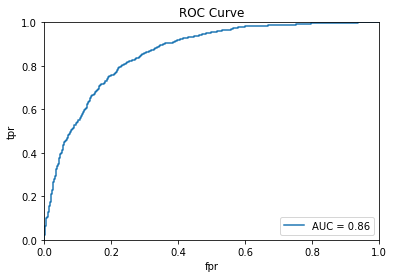

In [63]:
pre_prob_lasso = lassocv.predict(X_test)
fpr_lasso, tpr_lasso, thresholds_lasso = roc_curve(y_test, pre_prob_lasso)

plt.title('ROC Curve')
plt.plot(fpr_lasso, tpr_lasso, label = 'AUC = %0.2f' % roc_auc_score(y_test, pre_prob_lasso))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="lower right")
#plt.grid(True)
plt.show()

#### Cross-Validated RandomForest

In [64]:
param_grid = {
   'max_depth': [2,3,5,10,15,20],#to make sure depth doesn't go too deep, preventing overfitting
    'max_features': ['auto', 'sqrt',None],
    'min_samples_leaf': [4,6,8],#to make sure no leaf has too little sample, preventing overfitting
    'min_samples_split': [8,12, 16, 20],# to make sure no leaf has to little sample, preventing overfitting
    'n_estimators': [5,10,15,20,30]# to make sure the number of trees are moderate, leading to overfitting
}
rf1 = RandomForestClassifier(random_state=888)
grid_search_rf = GridSearchCV(estimator = rf1, scoring='f1', param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train,y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed:  3.5min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=888),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 15, 20],
                         'max_features': ['auto', 'sqrt', None],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [8, 12, 16, 20],
                         'n_estimators': [5, 10, 15, 20, 30]},
             scoring='f1', verbose=2)

In [65]:
y_hat_rf = grid_search_rf.best_estimator_.predict(X_test)

print('Accuracy Score for Random Forest is:', accuracy_score(y_test, y_hat_rf))
print('F1 Score for Random Forest is:', f1_score(y_test, y_hat_rf))
print('Precision Score for Random Forest is:', precision_score(y_test, y_hat_rf))
print('Recall Score for Random Forest is:', recall_score(y_test, y_hat_rf))

Accuracy Score for Random Forest is: 0.8233202986135798
F1 Score for Random Forest is: 0.8289156626506025
Precision Score for Random Forest is: 0.8010645375914837
Recall Score for Random Forest is: 0.8587731811697575


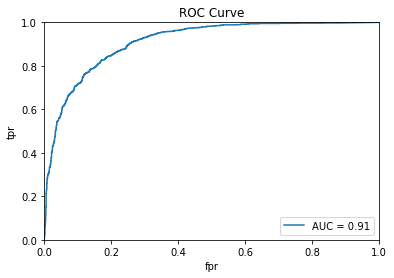

In [66]:
# plot ROC using training set
y_hat_rf_proba = grid_search_rf.best_estimator_.predict_proba(X_test)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_hat_rf_proba[:,1])

plt.title('ROC Curve')
plt.plot(fpr_rf, tpr_rf, label = 'AUC = %0.2f' % roc_auc_score(y_test, y_hat_rf_proba[:,1]))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend(loc="lower right")
#plt.grid(True)
plt.show()

#### Conclusion

The best model is 'Cross Validated Random Forest' and is recommended for fight predictions.

### Next Steps

Possible next steps could involve more advanced feature engineering - win streaks, loss streaks, weighted averages for punches landed & attempted, etc. Also, advanced models like neural networks could also be used. Ensemble methods could also be utilized to achieve better overall results combining multiple models.

# END